In [1]:
# Loading modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading data
tree_table = pd.read_csv('input_data/table.dat', sep = ',', header=None, names=['Parent', 'Child'])
branch_lengths = pd.read_csv('input_data/branchlength.dat', sep = ',', header=None)
branch_lengths = pd.DataFrame(branch_lengths.values.flatten(), columns=['Length'])
msa = pd.read_csv('input_data/msa.dat', sep = ' ', header=None)
merged_data = pd.concat([tree_table, branch_lengths], axis=1)
merged_data['Sequence'] = np.nan
merged_data['Sequence'] = merged_data['Sequence'].astype(object)
# Iterate over msa and update the 'sequence' column in merged_data
for index, row in msa.iterrows():
    child_value = row[0]
    sequence_value = ' '.join(map(str, row[1:]))
    merged_data.loc[merged_data['Child'] == child_value, 'Sequence'] = sequence_value

merged_data

,Parent,Child,Length,Sequence
0,9,1,0.10,AGATCAAGATCAAGATCAAGATCAAGATCA
1,9,2,0.40,AGCTCAAGCTCAAGCTCAAGCTCAAGCTCA
2,8,9,0.01,NaN
3,8,3,0.04,CGCTATCGCTATCGCTATCGCTATCGCTAT
4,7,4,0.20,CGTTACCGTTACCGTTACCGTTACCGTTAC
5,7,5,0.08,CGCTACCGCTACCGCTACCGCTACCGCTAC
6,6,7,0.12,NaN
7,6,8,0.14,NaN


In [3]:
# Creating the node class
class Node:

    def __init__(self, identity, parent=None, branch_length=None, sequence=None):
        self.identity = identity
        self.parent = parent
        self.branch_length = branch_length
        self.sequence = sequence
        self.children = []


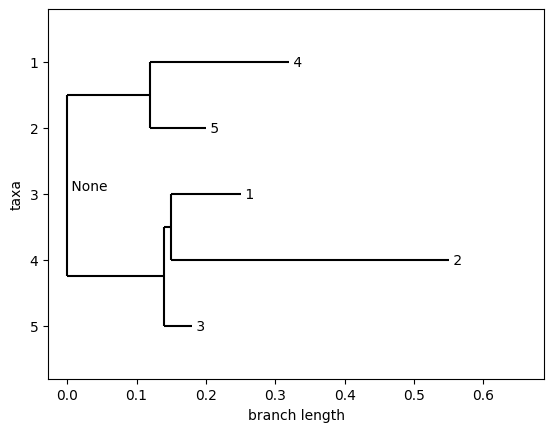

In [ ]:
import pandas as pd
import numpy as np
from scipy.linalg import expm
import time
from Bio import Phylo
from io import StringIO


Q = np.array([[-0.5625,0.1875,0.1875,0.1875],[0.1875,-0.5625,0.1875,0.1875],[0.1875,0.1875,-0.5625,0.1875],[0.1875,0.1875,0.1875,-0.5625]])

class Node:
    def __init__(self, name):
        self.name = name
        self.parent = None
        self.children = []
        self.branch_length = None
        self.sequence = None
        self.is_final = False

class Tree:
    def __init__(self, table, msa, branch_lengths, transition_matrix):
        self.data = self.get_data(table, msa, branch_lengths)
        self.root = None
        self.transition_matrix = transition_matrix
        self.populate_tree(self.data)
        self.tree_probability(self.nodes)

    def get_data(self, table, msa, branch_lengths):
        tree_table = pd.read_csv(table, sep=',', header=None, names=['Parent', 'Child'])
        branch_lengths = pd.read_csv(branch_lengths, sep=',', header=None)
        branch_lengths = pd.DataFrame(branch_lengths.values.flatten(), columns=['Length'])
        msa = pd.read_csv(msa, sep=' ', header=None)
        data = pd.concat([tree_table, branch_lengths], axis=1)
        data['Sequence'] = np.nan
        data['Sequence'] = data['Sequence'].astype(object)
        # Iterate over msa and update the 'sequence' column in merged_data
        for index, row in msa.iterrows():
            child_value = row[0]
            sequence_value = ''.join(map(str, row[1:]))
            data.loc[data['Child'] == child_value, 'Sequence'] = sequence_value
        return data

    def is_final_node(self, node_name):
        child_count = self.data['Child'].value_counts().get(node_name, 0)
        parent_count = self.data['Parent'].value_counts().get(node_name, 0)
        return child_count == 1 and parent_count == 0

    def populate_tree(self, data):
        # Create a dictionary to store the nodes
        nodes = {}
        # Iterate over the rows of the data
        for index, row in data.iterrows():
            parent = row['Parent']
            child = row['Child']
            branch_length = row['Length']
            sequence = row['Sequence']
            # If the parent is not in the dictionary, create a new node
            if parent not in nodes:
                nodes[parent] = Node(parent)
            # If the child is not in the dictionary, create a new node
            if child not in nodes:
                nodes[child] = Node(child)
            # Update the child node with the parent, branch length and sequence
            nodes[child].parent = nodes[parent]
            nodes[child].branch_length = branch_length
            nodes[child].sequence = sequence
            nodes[child].is_final = self.is_final_node(child)
            # Update the parent node with the child
            nodes[parent].children.append(nodes[child])
        # Set the root node (assuming the root has no parent)
        for node in nodes.values():
            if node.parent is None:
                self.root = node
                break
        self.nodes = nodes

    def one_hot_encode(self, sequence):
        if sequence is None or (isinstance(sequence, str) and sequence == ''):
            return np.array([])
        mapping = {
            'A': [1, 0, 0, 0],
            'C': [0, 1, 0, 0],
            'G': [0, 0, 1, 0],
            'T': [0, 0, 0, 1],
        }
        one_hot_sequence = [mapping[base] for base in sequence]
        return np.array(one_hot_sequence)

    def get_nucleotide_probability(self, node1, node2):
        prob_vector = []

        sequence1 = self.one_hot_encode(node1.sequence) if node1.is_final else node1.sequence
        sequence2 = self.one_hot_encode(node2.sequence) if node2.is_final else node2.sequence
        
        for i in range(len(sequence1)):
            exp_matrix1 = expm(self.transition_matrix * node1.branch_length)
            exp_matrix2 = expm(self.transition_matrix * node2.branch_length)
            transformed_seq1 = np.dot(exp_matrix1, sequence1[i])
            transformed_seq2 = np.dot(exp_matrix2, sequence2[i])
            prob_vector.append(transformed_seq1 * transformed_seq2)
        
        prob_vector = np.array(prob_vector)
        node1.parent.sequence = prob_vector
        return prob_vector


    def tree_probability(self, nodes):
        for node in nodes.values():
            if len(node.children)==2 and  all(child.sequence is not None for child in node.children):
                node.sequence = self.get_nucleotide_probability(node.children[0], node.children[1])

    def get_log_likelihood(self):
        eq_freq = np.array([0.25, 0.25, 0.25, 0.25])
        root_sequence_log = np.log(np.clip(self.root.sequence, 1e-10, None)) # Avoid log(0)
        log_likelihood = np.sum(root_sequence_log * eq_freq)
        return float(log_likelihood)


    def print_tree(self, node=None, level=0):
        if node is None:
            node = self.root
        one_hot_sequence = self.one_hot_encode(node.sequence) if node.is_final and node.sequence else None
        print(' ' * level * 4 + f'Node: {node.name}, Branch Length: {node.branch_length}, Sequence: {node.sequence}, Is Final: {node.is_final}')
        for child in node.children:
            self.print_tree(child, level + 1)

    def to_newick(self, node=None):
        if node is None:
            node = self.root
        if not node.children:
            return f"{node.name}:{node.branch_length}"  # Leaf node
        return f"({','.join(self.to_newick(child) for child in node.children)}):{node.branch_length}"

    def plot_with_biopython(self):
        newick_str = self.to_newick() + ";"
        handle = StringIO(newick_str)
        tree = Phylo.read(handle, "newick")
        Phylo.draw(tree)


# Example usage
tree = Tree('input_data/table.dat', 'input_data/msa.dat', 'input_data/branchlength.dat', Q)


tree.get_log_likelihood()
tree.plot_with_biopython()